# L2 - Multilayer perceptron

### Papers
1. [TensorFlow](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf)

### TensorFlow
1. [Installing TensorFlow](https://www.tensorflow.org/install/)
2. [Basics of TensorFlow](https://www.tensorflow.org/get_started/get_started)
3. [Mnist with TensorFlow](https://www.tensorflow.org/get_started/mnist/pros)
4. [TensorFlow Mechanics](https://www.tensorflow.org/get_started/mnist/mechanics)
5. [Visualization](https://www.tensorflow.org/get_started/graph_viz)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset with TensorFlow (possible, [this tutorial](https://www.tensorflow.org/get_started/mnist/pros) can help you).
4. Chek accuracy on train and validation sets.
5. Use a local [TensorBoard instance](https://www.tensorflow.org/get_started/graph_viz) to visualize resulted graph (no need to include in lab).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = np.array(pd.read_csv('data/train.csv'), dtype=np.float32)
labels = np.array(data[:, 0], dtype=np.int32)
data = data[:, 1:]
data /= 256.0
#data -= np.average(data, axis=1)[:, np.newaxis]
#data /= np.average(data**2, axis=1)[:, np.newaxis]

In [3]:
print(data.shape, labels.shape)

(42000, 784) (42000,)


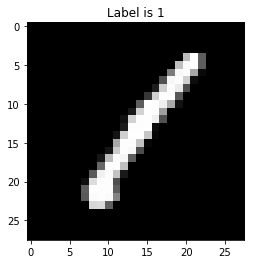

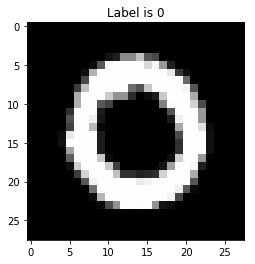

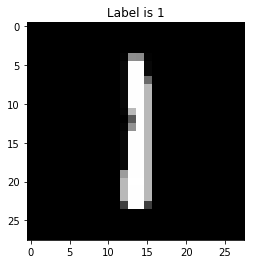

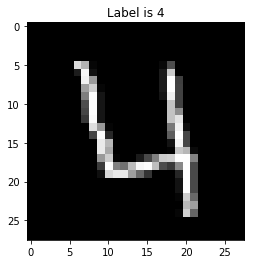

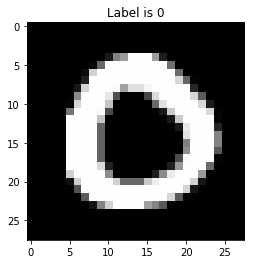

In [4]:
for i in range(5):
    img = np.array(data[i]).reshape((28, 28))
    plt.title('Label is ' + str(labels[i]))
    plt.imshow(img, cmap='gray')
    plt.show()

In [5]:
def shuffle(X, Y):
    shuffle = np.random.permutation(X.shape[0])
    return X[shuffle], Y[shuffle]

def cross_validation(X, Y, parts, cross_valid=True):
    X, Y = shuffle(X, Y)
    for i in range(parts):
        l = i * X.shape[0] // parts
        r = (i + 1) * X.shape[0] // parts
        test = np.zeros(X.shape[0], dtype=np.bool)
        test[l:r] = True
        if cross_valid or i == 0 :
            yield X[~test], Y[~test], X[test], Y[test]

def next_batch(X, Y, batch_size):
    #X, Y = shuffle(X, Y)
    for i in range(0, X.shape[0], batch_size):
        j = min(i + batch_size, X.shape[0])
        yield X[i:j], Y[i:j]

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
y_labels = tf.placeholder(tf.int32, shape=[None], name="labels")

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.matmul(x, W) + b

cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
batch_size = 64
acc_test = 0.0
acc_train = 0.0
parts = 5
epoches = 10
start = time.time()
with tf.Session() as sess:
    for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts):
        sess.run(tf.global_variables_initializer())
        for i in range(epoches):
            for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
        acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})
    acc_test /= parts
    acc_train /= parts

print(time.time() - start)
print("Accuracy on train set =", acc_train)
print("Accuracy on test set =", acc_test)
print("___________________________________")


34.554784059524536
Accuracy on train set = 0.931357145309
Accuracy on test set = 0.916976177692
___________________________________


In [8]:
x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
y_labels = tf.placeholder(tf.int32, shape=[None], name="labels")

y = tf.layers.dense(inputs=x,
                    units=10,
                    use_bias=True,
                   )

cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
batch_size = 64
acc_test = 0.0
acc_train = 0.0
parts = 5
epoches = 10
start = time.time()
with tf.Session() as sess:
    for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts):
        sess.run(tf.global_variables_initializer())
        for i in range(epoches):
            for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
        acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})
    acc_test /= parts
    acc_train /= parts

print(time.time() - start)
print("Accuracy on train set =", acc_train)
print("Accuracy on test set =", acc_test)
print("___________________________________")


27.676358222961426
Accuracy on train set = 0.924702382088
Accuracy on test set = 0.911523807049
___________________________________


Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [10]:
y = tf.layers.dense(inputs=x,
                    units=10,
                    use_bias=True,
                    kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=1e-4, scale_l2=1e-4)
                   )

cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y)) \
                + tf.losses.get_regularization_loss()

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
batch_size = 64
epoches = 5
parts = 5
acc_train = 0.0
acc_test = 0.0
cross_valid = False
with tf.Session() as sess:
    for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts, cross_valid=cross_valid):
        sess.run(tf.global_variables_initializer())
        for i in range(epoches):
            for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
        acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})
    
    if cross_validation:
        acc_train /= parts
        acc_test /= parts

    print("Accuracy on train set =", acc_train)
    print("Accuracy on test set =", acc_test)

Accuracy on train set = 0.184422624111
Accuracy on test set = 0.182000005245


### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [12]:
def compute_accuracy(sizes=[784, 10], nonlinearity="leakyrelu", alpha=0.1, lambda1 = 0.0, lambda2 = 0.0,
                     grad_speed=0.5, epoches=5, batch_size=64, parts=5, cross_valid=False):
    tf.get_variable_scope().reuse_variables()
    tf.reset_default_graph()
    if sizes[0] != 784:
        sizes.insert(0, 784)
    if sizes[-1] != 10:
        sizes.append(10)

    n = len(sizes)
    
    activation = 0
    if nonlinearity == "sigmoid":
        activation = tf.nn.sigmoid
    elif nonlinearity == "relu":
        activation = tf.nn.relu
    elif nonlinearity == "leakyrelu":
        def leaky_relu(features):
            return tf.nn.relu(features) - alpha * tf.nn.relu(features)
        activation = leaky_relu
    else:
        raise RuntimeError("I don't know this function")

    x = tf.placeholder(tf.float32, shape=[None, 784], name="data")
    y_labels = tf.placeholder(tf.int32, shape=[None], name="labels")
    
    x_interim = list()
    x_interim.append(x)
    for i in range(1, n - 1):
        x_interim.append(tf.layers.dense(inputs=x_interim[i - 1],
                                         units=sizes[i],
                                         activation=activation,
                                         use_bias=True,
                                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=lambda1,
                                                                                               scale_l2=lambda2
                                                                                              ),
                                         name="x" + str(i)
                                        )
                        )
                                  
                                    
    y = tf.layers.dense(inputs=x_interim[-1],
                       units=sizes[-1],
                       use_bias=True,
                       kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=lambda1,
                                                                              scale_l2=lambda2
                                                                             ),
                        name="y"
                      )

    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y)) \
                    + tf.losses.get_regularization_loss()

    train_step = tf.train.GradientDescentOptimizer(grad_speed).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                     
    acc_train = 0.0
    acc_test = 0.0
    with tf.Session() as sess:
        writer = tf.summary.FileWriter("/tmp/log/tensorflow/lab-2", sess.graph)
        for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts, cross_valid=cross_valid):
            sess.run(tf.global_variables_initializer())
            for i in range(epoches):
                for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                    sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

            acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
            acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})

        if (cross_valid):
            acc_train /= parts
            acc_test /= parts
        writer.close()
    return acc_train, acc_test

In [58]:
s = [200]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")



Train and test accuracity with sizes = [784, 200, 10] 
train = 0.990208339691 	test = 0.968976187706 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 200, 10] 
train = 0.99099406004 	test = 0.972595238686 



In [64]:
s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.1, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.973523807526 	test = 0.961071431637 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.966285717487 	test = 0.955047631264 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.973565471172 	test = 0.961952388287 



In [65]:
s = [196, 49]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.1, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 196, 49, 10] 
train = 0.968601191044 	test = 0.956880950928 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.969916653633 	test = 0.956690478325 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.976184511185 	test = 0.963642859459 



In [66]:
s = [392, 196, 49]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.05, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=2, cross_valid=True,
                              nonlinearity="leakyrelu",
                              alpha=0.1, lambda1=0.0, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 49, 10] 
train = 0.974113094807 	test = 0.961738085747 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.970690476894 	test = 0.958333325386 

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.973184537888 	test = 0.960738098621 



In [76]:
s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=False,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-3, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=False,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-4, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=False,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-5, lambda2=0.0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.818690478802 	test = 0.826071441174 

Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.977053582668 	test = 0.968095242977 

Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.994494020939 	test = 0.97452378273 



In [19]:
s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=40, cross_valid=False,
                              nonlinearity="leakyrelu",
                              alpha=0.05, lambda1=4.5 * 1e-5, lambda2=4.5 * 1e-5)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

Train and test accuracity with sizes = [784, 392, 196, 98, 10] 
train = 0.985535740852 	test = 0.967857122421 



In [75]:

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-0, lambda2=1e-0)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-1, lambda2=1e-1)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [392, 196, 98]
acc1, acc2 = compute_accuracy(sizes=s, epoches=10, cross_valid=True,
                              nonlinearity="relu",
                              alpha=0.1, lambda1=1e-2, lambda2=1e-2)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

KeyboardInterrupt: 

In [18]:
s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True, alpha=0.05, lambda1=1e-6, lambda2=1e-6)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

KeyboardInterrupt: 

In [ ]:
s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True, alpha=0.05, lambda1=1e-6, lambda2=1e-6)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

In [90]:
'''
sizes=[200, 100] #оч примерно
nonlinearity="leakyrelu"
alpha=0.05 [-0.025, +0.025]
batch_size=64 [-16, +32]
epoches=20
'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-90-f1ae42e57f7f>, line 6)

In [155]:
s = [400]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [300]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [400]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [300]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")


Train and test accuracity with sizes = [784, 400, 10] 
train =  0.990951156616 	test = 0.969833564758 

Train and test accuracity with sizes = [784, 300, 10] 
train =  0.988707113266 	test = 0.967428779602 

Train and test accuracity with sizes = [784, 200, 10] 
train =  0.986701154709 	test = 0.967047858238 

Train and test accuracity with sizes = [784, 100, 10] 
train =  0.982873821259 	test = 0.965333533287 

Train and test accuracity with sizes = [784, 400, 10] 
train =  0.999986839294 	test = 0.976262152195 

Train and test accuracity with sizes = [784, 300, 10] 
train =  0.999957084656 	test = 0.975690710545 

Train and test accuracity with sizes = [784, 200, 10] 
train =  0.999945187569 	test = 0.974714517593 

Train and test accuracity with sizes = [784, 100, 10] 
train =  0.999635589123 	test = 0.972333538532 



In [94]:
s = [150]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")


AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'leaky_relu'

In [165]:
s = [150, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [100, 50]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [150, 100, 50]
acc1, acc2 = compute_accuracy(sizes=s, epoches=5, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [150, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [100, 50]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [150, 100, 50]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")


Train and test accuracity with sizes = [784, 150, 100, 10] 
train = 0.988457083702 	test = 0.968976426125 

Train and test accuracity with sizes = [784, 100, 50, 10] 
train = 0.981867849827 	test = 0.964881181717 

Train and test accuracity with sizes = [784, 150, 100, 50, 10] 
train = 0.980439293385 	test = 0.963428783417 

Train and test accuracity with sizes = [784, 150, 100, 10] 
train = 0.999867773056 	test = 0.977428817749 

Train and test accuracity with sizes = [784, 100, 50, 10] 
train = 0.995927298069 	test = 0.970714509487 

Train and test accuracity with sizes = [784, 150, 100, 50, 10] 
train = 0.995433282852 	test = 0.972476410866 



In [166]:
s = [150, 125, 100, 75, 50, 25]
acc1, acc2 = compute_accuracy(sizes=s, epoches=30, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

Train and test accuracity with sizes = [784, 150, 125, 100, 75, 50, 25, 10] 
train = 0.458261400461 	test = 0.449309591949 



In [173]:
s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.0, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.05, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.1, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.15, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.2, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

s = [200, 100]
acc1, acc2 = compute_accuracy(sizes=s, epoches=20, alpha=0.25, cross_valid=True)
print("Train and test accuracity with sizes =", s, "\ntrain =", acc1, "\ttest =", acc2, "\n")

Train and test accuracity with sizes = [784, 200, 100, 10] 
train = 0.999861824512 	test = 0.977238333225 

Train and test accuracity with sizes = [784, 200, 100, 10] 
train = 0.999998748302 	test = 0.977809762955 

Train and test accuracity with sizes = [784, 200, 100, 10] 
train = 0.999843978882 	test = 0.97664308548 

Train and test accuracity with sizes = [784, 200, 100, 10] 
train = 0.997504663467 	test = 0.974381196499 

Train and test accuracity with sizes = [784, 200, 100, 10] 
train = 0.991582095623 	test = 0.967928814888 



KeyboardInterrupt: 

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.

In [ ]:
def autoincoder(sizes=[784], nonlinearity="leakyrelu", alpha=0.1, lambda1 = 0.0, lambda2 = 0.0,
                     grad_speed=0.5, epoches=5, batch_size=64, parts=5, cross_valid=False):
    tf.get_variable_scope().reuse_variables()
    tf.reset_default_graph()
    if sizes[0] != 784:
        sizes.insert(0, 784)

    n = len(sizes)

    activation = 0
    if nonlinearity == "sigmoid":
        activation = tf.nn.sigmoid
    elif nonlinearity == "relu":
        activation = tf.nn.relu
    elif nonlinearity == "leakyrelu":
        def leaky_relu(features):
            return tf.nn.relu(features) - alpha * tf.nn.relu(features)
        activation = leaky_relu
    else:
        raise RuntimeError("I don't know this function")

    x = tf.placeholder(tf.float32, shape=[None, 784], name="data")

    x_interim = list()
    x_interim.append(x)
    for i in range(1, n - 1):
        x_interim.append(tf.layers.dense(inputs=x_interim[i - 1],
                                         units=sizes[i],
                                         activation=activation,
                                         use_bias=True,
                                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=lambda1,
                                                                                               scale_l2=lambda2
                                                                                              ),
                                         name="x" + str(i)
                                        )
                        )

    for i in range(1, n - 1):
        x_interim.append(tf.layers.dense(inputs=x_interim[i - 1],
                                         units=sizes[i],
                                         activation=activation,
                                         use_bias=True,
                                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=lambda1,
                                                                                               scale_l2=lambda2
                                                                                              ),
                                         name="x" + str(i)
                                        )
                        )

    y = tf.layers.dense(inputs=x_interim[-1],
                       units=sizes[-1],
                       use_bias=True,
                       kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale_l1=lambda1,
                                                                              scale_l2=lambda2
                                                                             ),
                        name="y"
                      )

    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=y)) \
                    + tf.losses.get_regularization_loss()

    train_step = tf.train.GradientDescentOptimizer(grad_speed).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1, output_type=tf.int32), y_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    acc_train = 0.0
    acc_test = 0.0
    with tf.Session() as sess:
        writer = tf.summary.FileWriter("/tmp/log/tensorflow/lab-2", sess.graph)
        for X_train, Y_train, X_test, Y_test in cross_validation(data, labels, parts, cross_valid=cross_valid):
            sess.run(tf.global_variables_initializer())
            for i in range(epoches):
                for batch_x, batch_y in next_batch(X_train, Y_train, batch_size):
                    sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

            acc_train += sess.run(accuracy, feed_dict={x: X_train, y_labels: Y_train})
            acc_test += sess.run(accuracy, feed_dict={x: X_test, y_labels: Y_test})

        if (cross_valid):
            acc_train /= parts
            acc_test /= parts
        writer.close()
    return acc_train, acc_test